# Multi-Layer Perceptron with CIFAR10 classification 

## 1. Module Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1  Device: cpu


## 3. CIFAR10 데이터 다운로드 (Train data와 Test data 분리하기)

In [3]:
BATCH_SIZE = 32 

train_data = datasets.CIFAR10 ('data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10 ('data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader (dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader (dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## 4. 첫번째 batch 데이터의 크기와 타입을 확인하기

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


## 4. torch.nn을 이용하여 모델 만들기

   1) input layer (입력층), hidden layer (은닉층), output layer (출력층) 으로 이루어진 모델을 이용

   2) 하나의 hidden layer (은닉층)만 이용 - 은닉층의 개수는 100개로 하세요
   
   3) nn.Module을 상속 받아 만들 것!
   
   4) nn.Linear와 nn.ReLU를 사용할 것!


In [5]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(3072, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 5. 초기화를 위한 함수 만들기

In [6]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data, 0)
        nn.init.constant_(m.bias.data, 0)
        
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.01)
        nn.init.constant_(m.bias.data, 0)
        #채우시오        

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

        #채우시오
        
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
        #채우시오

## 6. 모델 객체 만들고 다르게 초기화 하기

In [7]:
########## 아래 채우시오에 함수명을 적으면됩니다.

network_const = Model()
network_const.apply(init_constants)

network_normal = Model()
network_normal.apply(init_normal)

network_xaiver = Model()
network_xaiver.apply(init_xaiver)

network_kaiming = Model()
network_kaiming.apply(init_kaiming)


Model(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

## 7. 학습 준비하기

1) 1 epoch를 학습할 수 있는 함수 만들기

2) 1 테스트 데이터의 정확도 계산할 수 있는 함수 만들기

In [9]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 500
    
    for batch_idx, (image, label) in enumerate(train_loader):
        # 미분값의 초기화
        optimizer.zero_grad()
        #채우시오

        # 이미지를 (batch_size, 784) 차원의 메트릭스로 만드세요
        batch_size = image.size()[0]
        image = image.view(batch_size, -1)#채우시오

        # Forward propagration 계산하기.
        outputs = network(image)#채우시오
        
        
        # Cross_entropy 함수를 적용하여 loss를 구하고 저장하기
        loss = loss_func(outputs, label)#채우시오
        train_losses.append(loss.item())

        # training accuracy 정확도 구하기 위해 맞는 샘플 개수 세기
        pred = outputs.data.max(1, keepdim=True)[1] #채우시오
        train_correct += pred.eq(label.view_as(pred)).sum().item()

        # Gradinet 구하기
        loss.backward()
        #채우시오

        # weight값 update 하기
        #채우시오
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(epoch, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses, train_correct

In [10]:
def test_epoch(test_loader, network, loss_func):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (image, label) in enumerate(test_loader):
            batch_size = image.size()[0]
            image = image.view(batch_size, -1)#채우시오

            # Forward propagration 계산하기.
            outputs = network(image)#채우시오

            # Cross_entropy 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)#채우시오
            test_losses.append(loss.item())

            # Batch 별로 정확도 구하기
            pred = outputs.data.max(1, keepdim = True)[1]#채우시오
            correct += pred.eq(label.view_as(pred)).sum()

        # 전체 정확도 구하기
        test_accuracy = 100. * correct / len(test_loader.dataset)

        #중간결과 출력
        print('Test set: Accuracy: {}/{} ({:.0f}%)\n'
              .format(correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
    return test_losses, test_accuracy


## 7. 위 정의된 함수로 학습 함수 만들기

In [11]:
def training(network):
    
    learning_rate = 0.01
    epoches = 20
    
    cls_loss = nn.CrossEntropyLoss() #채우시오
    optimizer = optim.SGD(network.parameters(), lr = learning_rate)#채우시오 SGD로 만드시오
    
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    
    train_accuracies = []
    test_accuracies = []
    
    
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        #채우시오
        
        train_losses, train_correct = training_epoch(train_loader,network, cls_loss, optimizer, epoch)#채우시오
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        train_accuracy = train_correct / len(train_loader.dataset) * 100
        train_accuracies.append(train_accuracy)
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Accuracy: {}/{} ({:.0f}%)'
              .format(train_correct, len(train_loader.dataset),100. * train_correct / len(train_loader.dataset)))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            test_losses, test_accuracy = test_epoch(test_loader, network, cls_loss) #채우시오

        test_losses_per_epoch.append(np.mean(test_losses))
        test_accuracies.append(test_accuracy)
        
    return train_losses_per_epoch, test_losses_per_epoch, train_accuracies, test_accuracies


In [12]:
rlt_const = training( network_const)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.301526
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.303564
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.301433

Training set: Accuracy: 4844/50000 (10%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.303619
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.301910
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.303573
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.301404

Training set: Accuracy: 4730/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.303838
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.301992
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.301399

Training set: Accuracy: 4738/50000 (9%)
Test set: Accuracy: 1000/10000 (10%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.303884
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.302010
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.303575
Train Epoch: 3 [48000/50000 (96%

In [13]:
rlt_normal = training(network_normal)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.298916
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.055536
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.956350
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.142454

Training set: Accuracy: 12392/50000 (25%)
Test set: Accuracy: 3162/10000 (32%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.881629
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.822782
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.806459
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.150873

Training set: Accuracy: 17245/50000 (34%)
Test set: Accuracy: 3692/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.772822
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.705118
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.746212
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.146568

Training set: Accuracy: 18963/50000 (38%)
Test set: Accuracy: 3907/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.772723
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.584694
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.707636
Train Epoch: 3 [48000/50000

In [14]:
rlt_xaiver = training(network_xaiver)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.716100
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.827860
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.820728
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.267507

Training set: Accuracy: 16013/50000 (32%)
Test set: Accuracy: 3595/10000 (36%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.793005
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.715436
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.762247
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.259246

Training set: Accuracy: 19510/50000 (39%)
Test set: Accuracy: 3826/10000 (38%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.797040
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.641308
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.708170
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.204001

Training set: Accuracy: 20862/50000 (42%)
Test set: Accuracy: 3868/10000 (39%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.766734
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.578308
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.670307
Train Epoch: 3 [48000/50000

In [15]:
rlt_kaiming = training(network_kaiming)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.452442
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.923388
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.855653
Train Epoch: 0 [48000/50000 (96%)]	Loss: 2.176646

Training set: Accuracy: 16042/50000 (32%)
Test set: Accuracy: 3170/10000 (32%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.879086
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.653692
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.797198
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.129462

Training set: Accuracy: 19578/50000 (39%)
Test set: Accuracy: 3444/10000 (34%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.916851
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.559153
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.734944
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.109515

Training set: Accuracy: 20923/50000 (42%)
Test set: Accuracy: 3689/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.894389
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.500285
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.738735
Train Epoch: 3 [48000/50000

# 학습 결과 보기 
## 1. loss 값 비교

In [16]:
def show_rlt(rlt,title):
    fig = plt.figure(figsize=(15,5))

    fig.suptitle(title)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    x = np.arange(1,21)
  
    ax1.plot(x,rlt[0], x,rlt[1])
    ax1.legend(['training', 'test'])
    ax1.set_xlabel('Epoches --->')
    ax1.set_ylabel('Loss --->')
    ax1.set_xlim([0,21])
    
    ax2.plot(x,rlt[2],x,rlt[3])
    ax2.legend(['training', 'test'])
    ax2.set_xlabel('Epoches --->')
    ax2.set_ylabel('Accuracy --->')
    ax2.set_xlim([0,21])

    plt.show()

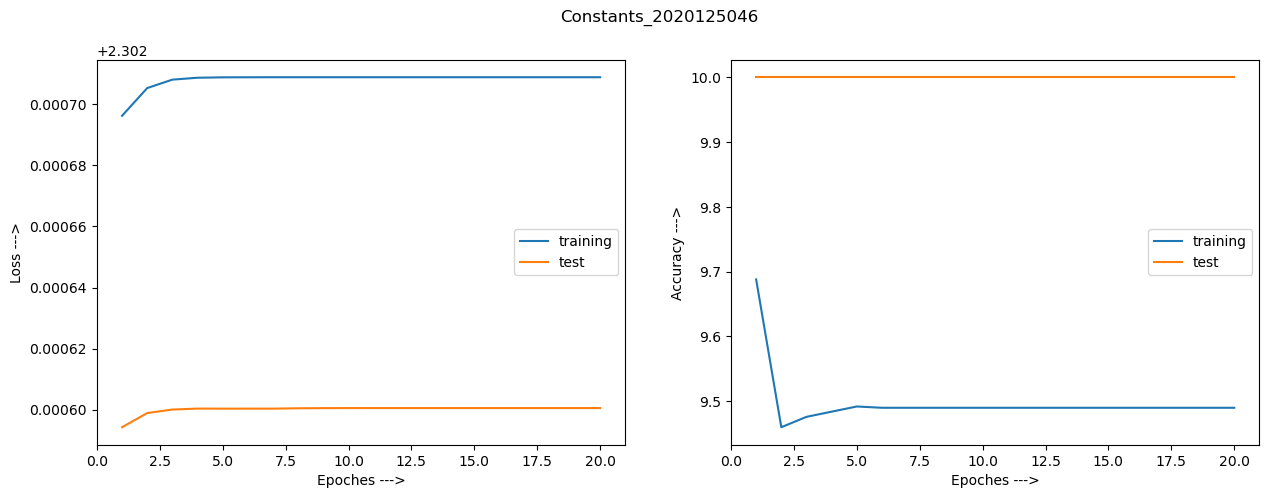

In [17]:
show_rlt(rlt_const, 'Constants_2020125046')

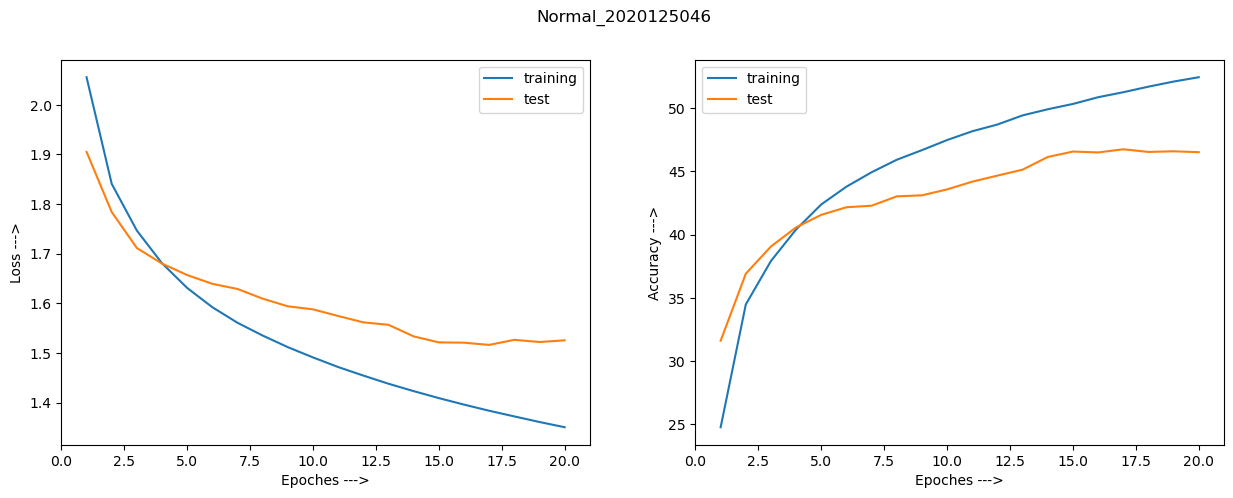

In [18]:
show_rlt(rlt_normal, 'Normal_2020125046')

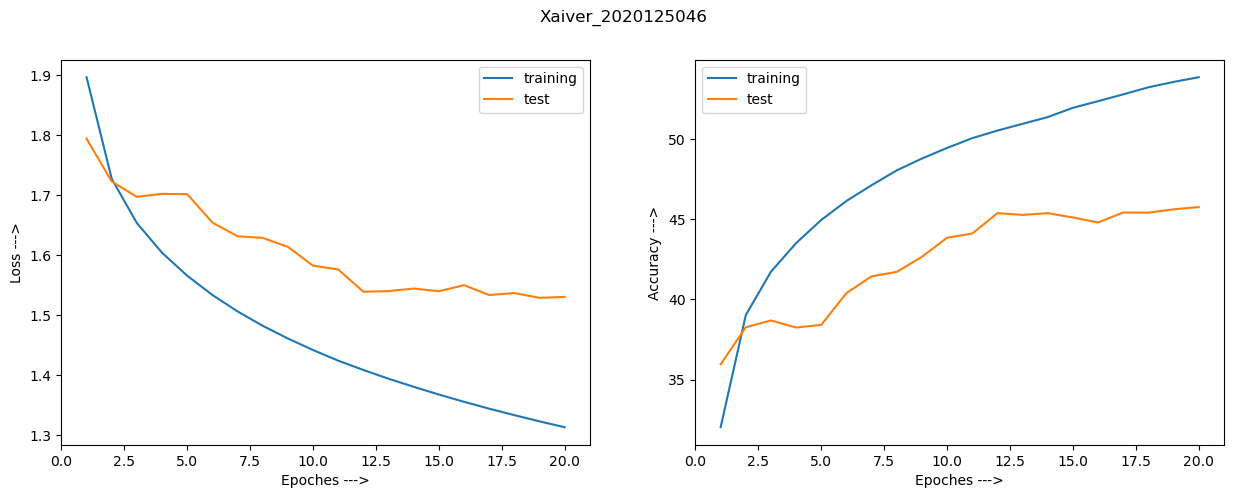

In [19]:
show_rlt(rlt_xaiver, 'Xaiver_2020125046')

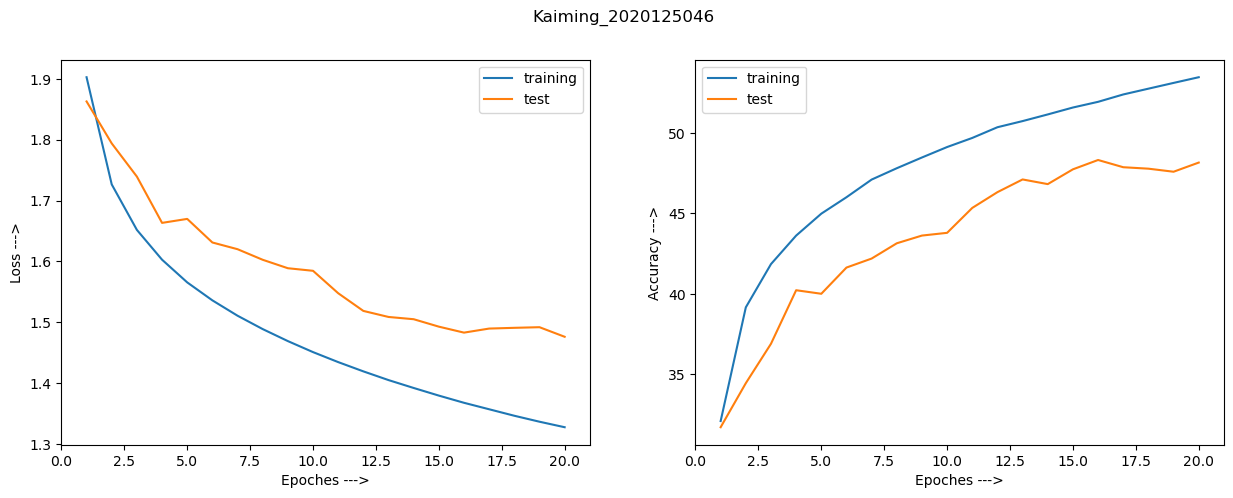

In [20]:
show_rlt(rlt_kaiming, 'Kaiming_2020125046')

## 2. 위 4개의 초기화 방법를 비교하고 성능에 대해서 분석하시오

정답) Constants: 가중치와 편향이 상수로 초기화되어 있기 때문에, 모델의 성능이 개선되지 않음. 안쓰는 것이 좋음.
Normal: 손실이 감소하고 정확도가 향상됨. 하지만, 이 방법이 최적의 성능은 아님.
Xaiver: 손실이 빠르게 감소하고 정확도가 높아짐. 효과적인 초기화 방법
Kaiming: 빠르게 수렴하며 높은 정확도를 보여줌. ReLU 활성화 함수를 사용하는 신경망에 적합.
Xaiver와 Kaiming 초기화 방법이 더 높은 성능을 제공하므로, 이러한 방법들을 우선적으로 고려하는 것이 좋을 것 같음






In [21]:
print("2020125046 이서영")

2020125046 이서영
